<a href="https://colab.research.google.com/github/HongEnJung/ML-DL/blob/main/Kaggle%20/Customer_Segmentation/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
warnings.filterwarnings('ignore')
init_notebook_mode(connected =True)
warnings.filterwarnings('ignore')
plt.rcParams['patch.force_edgecolor']=True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
# 파일 불러오기
df_initial = pd.read_csv('/content/drive/MyDrive/캐글/customer segmentation/data.csv', encoding='ISO-8859-1',dtype={'CustomerID':str, 'InvoiceID':str})
print('DataFrame dimensions:', df_initial.shape)

# 날짜로 변경
df_initial['InvoiceDate']= pd.to_datetime(df_initial['InvoiceDate'])


DataFrame dimensions: (541909, 8)


In [3]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df_initial.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df_initial.dropna(axis =0, subset =['CustomerID'], inplace=True)
print('DataFrame dimensions:', df_initial.shape)

DataFrame dimensions: (406829, 8)


In [6]:
df_initial.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
# 중복된 행 제거
print('Entrees dupliquees:{}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Entrees dupliquees:5225


InvoiceNo (송장 번호): 거래를 나타내는 송장 번호입니다. 6자리의 정수로 각 거래마다 고유하게 할당됩니다. 만약 이 코드가 문자 'c'로 시작한다면, 해당 거래는 취소된 것을 나타냅니다.

StockCode (상품 코드): 제품(아이템)을 식별하는 상품 코드입니다. 각 제품에 고유하게 할당된 5자리의 정수로 표현됩니다.

Description (상품 설명): 제품(아이템)의 이름을 나타내는 변수입니다. 텍스트 형태로 상품의 이름이 기록되어 있습니다.

Quantity (수량): 각 제품(아이템)의 거래당 수량입니다. 수치 형태로 표현됩니다.

InvoiceDate (송장 날짜): 거래가 생성된 날짜와 시간을 나타내는 변수입니다. 시간 정보를 포함한 날짜 데이터로 표현됩니다.

UnitPrice (단가): 제품(아이템)의 단위 가격을 나타내는 변수입니다. 영국 파운드(£)로 표현되는 수치 형태입니다.

CustomerID (고객 번호): 고객을 식별하는 고유한 5자리 정수입니다. 각 고객마다 고유한 번호가 할당됩니다.

Country (국가): 각 고객이 거주하는 국가의 이름을 나타내는 변수입니다. 텍스트 형태로 국가 이름이 기록되어 있습니다.

In [8]:
print(df_initial['Country'].unique(),'\n')
print("국가 수: ",len(df_initial['Country'].unique()))

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA'] 

국가 수:  37


In [9]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

In [10]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [11]:
countries.head(5)

United Kingdom    19857
Germany             603
France              458
EIRE                319
Belgium             119
Name: Country, dtype: int64

Customers and products

In [12]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceDate'].value_counts()),
               'customers' : len(df_initial['CustomerID'].value_counts())}],
             columns = ['products','transactions','customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,20460,4372


In [13]:
temp = df_initial.groupby(by = ['CustomerID','InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate': 'Number of products'})
nb_products_per_basket.sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
...,...,...,...
22177,18283,557956,76
22186,18283,580872,50
22188,18287,570715,38
22187,18287,554065,29


Cancelling orders

In [14]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
nb_products_per_basket.head(5)

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [15]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%)'.format(n1,n2,n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%)


In [16]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


In [17]:
df_check = df_initial[df_initial['Quantity'] < 0 ][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in df_check.iterrows():
  if df_initial[(df_initial['CustomerID']==col[0]) & (df_initial['Quantity'] == -col[1]) &
                (df_initial['Description'] == col[2])].shape[0] == 0: # 대응하는 양수 수량 항목이 존재하지 않을 경우를 확인하는 조건
    print(df_check.loc[index])
    break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object


In [18]:
df_initial[(df_initial['CustomerID'] == '14527') & (df_initial['UnitPrice'] == 27.5)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5,14527,United Kingdom


In [19]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount') ][
    ['CustomerID','Quantity','StockCode','Description','UnitPrice']]

for index, col in df_check.iterrows():
  if df_initial[(df_initial['CustomerID']==col[0]) & (df_initial['Quantity'] == -col[1]) &
                (df_initial['Description'] == col[2])].shape[0] == 0: # 대응하는 양수 수량 항목이 존재하지 않을 경우를 확인하는 조건
    print(df_check.loc[index])
    break

CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object


In [20]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in df_initial.iterrows():
  # 만약 주문량이 양수이거나, 할인상품인 경우 취소상품이 아니므로 스킵
  if (col['Quantity'] > 0) or col['Description'] == 'Discount' : continue
  # 동일한 고객, 상품코드, 송장일자, 주문수량이 양수인 행들을 선택하여 생성
  df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                       (df_initial['StockCode'] == col['StockCode']) &
                       (df_initial['InvoiceDate'] < col['InvoiceDate']) & # 취소 주문보다 이전의 경우
                       (df_initial['Quantity'] > 0)].copy()

  # 취소건 주문에 대응하는 주문이 없는 경우
  if (df_test.shape[0] == 0) :
    doubtfull_entry.append(index) # 의심되는 주문

  # 취소건 주문에 대응하는 주문이 하나인 경우
  elif (df_test.shape[0] == 1):
    index_order = df_test.index[0]
    # 주문수량을 음수로 기록하여 삭제할 준비를 한다.
    df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
    entry_to_remove.append(index)

  # 취소건 주문에 대응하는 주문이 여러개인 경우
  elif (df_test.shape[0] >1):
    # 인덱스 역순으로 정렬하여 최근 주문 조회
    df_test.sort_index(axis =0, ascending=False, inplace =True)
    for ind, val in df_test.iterrows():
      # 취소된 주문의 수량을 초과하는 주문들은 무시
      if val['Quantity'] < -col['Quantity']: continue
      df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
      entry_to_remove.append(index)
      break

In [21]:
print('entry_to_remove:{}'.format(len(entry_to_remove)))
print('doubtfull_entry: {}'.format(len(doubtfull_entry)))

entry_to_remove:7521
doubtfull_entry: 1226


In [22]:
df_cleaned.drop(entry_to_remove, axis =0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis =0, inplace=True)

# 주문취소건에 상품코드가 D(할인코드)가 아닌 주문 필터링
remaining_entrires = df_cleaned[(df_cleaned['Quantity'] < 0) &
                                (df_cleaned['StockCode'] != 'D')]
print('nb of entries to delete : {}'. format(remaining_entrires.shape[0]))
remaining_entrires[:5]

nb of entries to delete : 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [23]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


Stockcode

In [24]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [25]:
for code in list_special_codes:
  print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]) )

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


Basket Price

In [26]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [27]:
# 고객별 송장별 구매액
temp = df_cleaned.groupby(by=['CustomerID','InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID','InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis =1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Selection des entrees significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID').head(10)

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000
7,12347,581180,224.82,2011-12-07 15:52:00.000000000
8,12348,539318,892.80,2010-12-16 19:09:00.000000000
9,12348,541998,227.44,2011-01-25 10:42:00.000000000
10,12348,548955,367.00,2011-04-05 10:47:00.000000000


In [28]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (15.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123105 files and dir

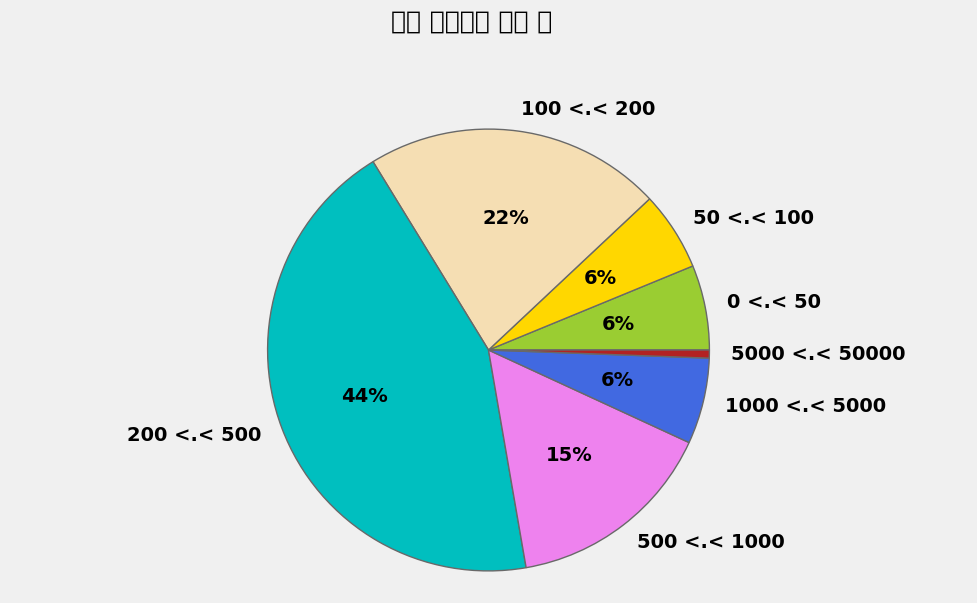

In [29]:
# 구매 금액대 지정
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = [] # 주문 수
for i, price in enumerate(price_range):
  if i == 0: continue # 0~50 구간 스킵
  val = basket_price[(basket_price['Basket Price'] < price)&
                     (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count() # i-1은 현재 가격 범위의 이전 가격 범위
  count_price.append(val)

# 데이터 시각화 (파이 차트)
plt.rc('font', weight = 'bold') # 폰트의 두께를 bold로 설정
f, ax = plt.subplots(figsize = (11,6)) # 가로 11, 세로 6
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ['{} <.< {}'.format(price_range[i-1],s) for i,s in enumerate(price_range) if i != 0] # 가격범위 시작 <.< 끝
sizes = count_price
# sizes 리스트의 값이 100보다 작은 경우 해당 섹션은 튀어나오지 않도록 0.0으로 설정되며
# 100보다 큰 경우에는 튀어나오도록 0.0이 아닌 다른 값을 가짐
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels =labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal') # 그래프 모양을 정확히 원으로 표현
f.text(0.5, 1.01, '구매 금액대별 주문 수', ha = 'center', fontsize = 18)
plt.show()


#### Insight on product categories

Products Description

In [30]:
# 자연어 처리(NLP) 기술을 사용하여 유사한 키워드를 식별하고 그룹화하는 작업
is_noun = lambda pos: pos[:2] == 'NN' # 형태소가 명사인지 확인

def keywords_inventory(dataframe, colonne = 'Description'):
  stemmer = nltk.stem.SnowballStemmer('english') # 영어 단어의 어간(stem)을 추출하는데 사용할 스노우볼 스태머(stemmer)를 생성
  keywords_roots = dict() # root 뿌리
  keywords_select = dict() # root <-> keyword 연결
  category_keys = [] # 키워드들을 그룹화하여 선택된 키워드를 저장
  count_keywords = dict() #키워드별 빈도수를 저장
  icount = 0

  for s in dataframe[colonne]:
    if pd.isnull(s) : continue
    lines = s.lower() # 소문자 변환
    tokenized = nltk.word_tokenize(lines) # 소문자로 변환한 문자열을 토큰화 하여 단어로 분할
    nouns =[word for (word, pos) in  nltk.pos_tag(tokenized) if is_noun(pos)] # 단어 중 명사만 추출, nltk.pos_tag 통해 품사 확인

    for t in nouns: # 추출된 명사를 반복
      t = t.lower()
      racine = stemmer.stem(t) # 현재 명사를 스노우볼 스태머 이용하여 원형으로 변환
      if racine in keywords_roots: # 원형으로 변형된 단어가 root에 이미 존재하는 경우
        keywords_roots[racine].add(t) # 원형 집합에 현재 단어 추가
        count_keywords[racine] += 1 # 빈도수 +1
      else: # 없는 경우
        keywords_roots[racine] = {t} # 생성하고 단어 추가
        count_keywords[racine] = 1 # 빈도수 1로 초기화

  for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1:
      min_length = 1000 # 변수에 매우 큰값을 초기화, 가장 작은 키워드 길이가 저장
      for k in keywords_roots[s]:
        if len(k) < min_length:
          clef = k; min_length =len(k)
      category_keys.append(clef)
      keywords_select[s] = clef
    else:
      category_keys.append(list(keywords_roots[s])[0])
      keywords_select[s] = list(keywords_roots[s])[0]

  print("Nb of keywords in variable '{}' :{}".format(colonne, len(category_keys)))
  return category_keys, keywords_roots, keywords_select, count_keywords

즉, 위 코드는 각 뿌리에 대해 여러 개의 키워드가 있는 경우 가장 짧은 키워드를 선택하고, 유일한 키워드가 있는 경우 그 키워드를 선택하여 category_keys 리스트에 정리하고, keywords_select 딕셔너리에 선택된 키워드를 기록하는 작업을 수행함

In [31]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns={0:'Description'})

In [32]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [33]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description' :1483


In [34]:
list_products = []
for k, v in count_keywords.items(): # k 키워드, v 카운트 값
  list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

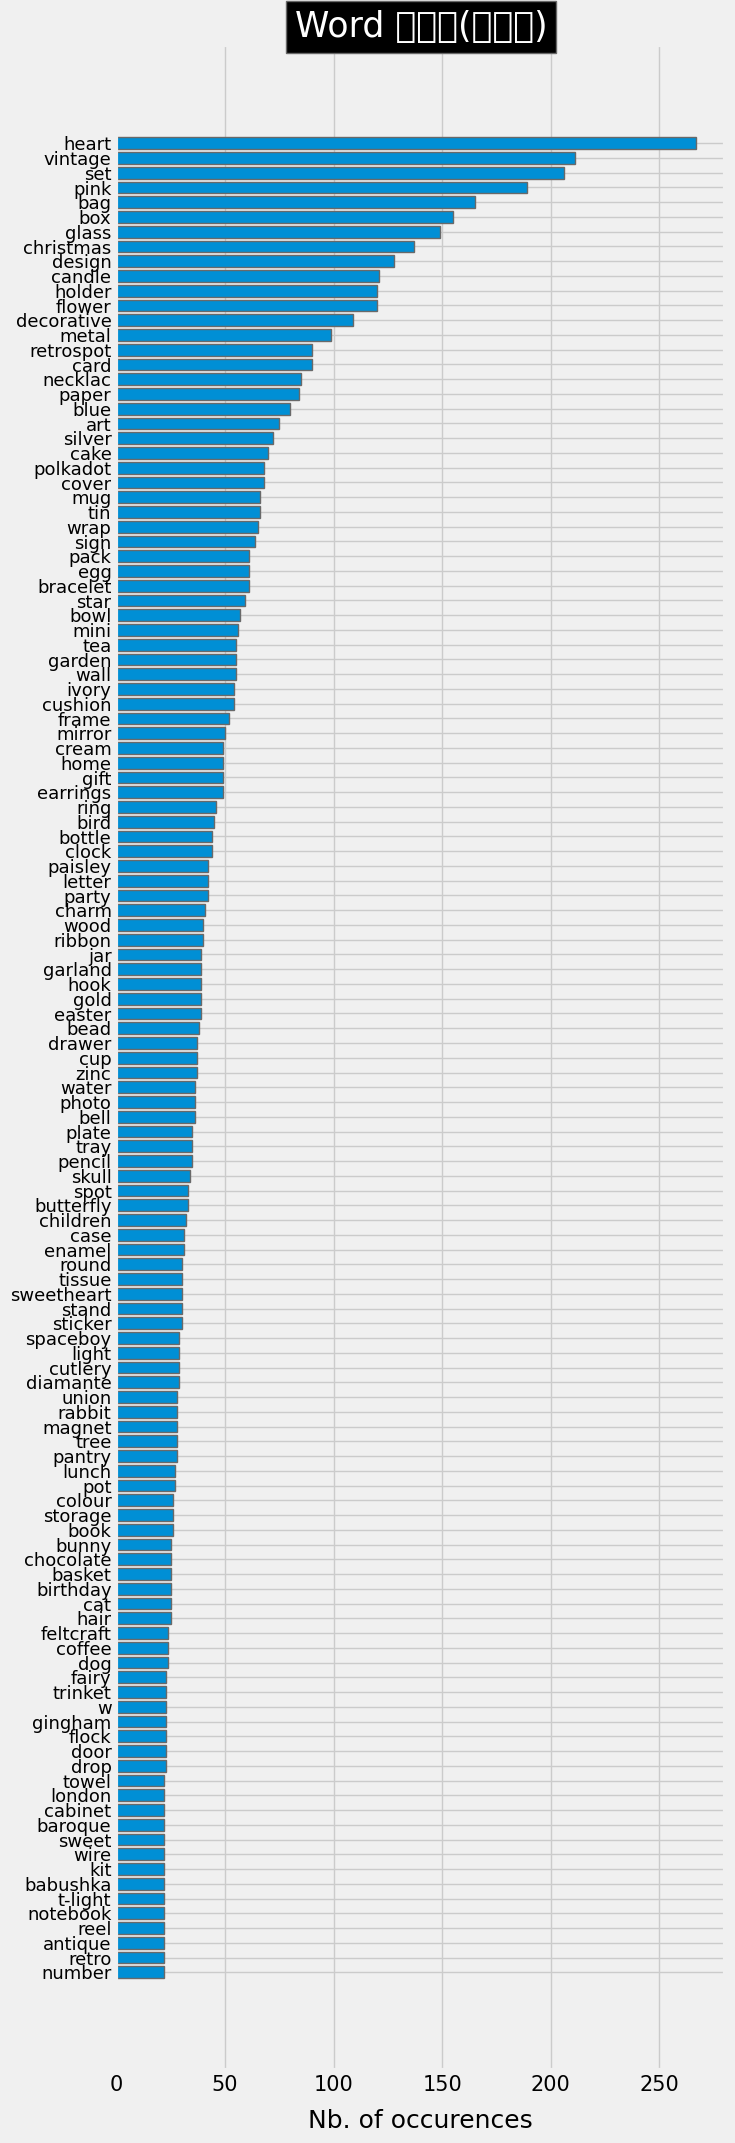

In [35]:
liste = sorted(list_products, key = lambda x:x[1], reverse =True)

plt.rc('font', weight = 'normal')
plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize = (7,25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label =[i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel('Nb. of occurences', fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align ='center')
ax =plt.gca()
ax.invert_yaxis()

plt.title('Word 빈도수(발생률)', bbox={'facecolor':'k', 'pad':5}, color='w', fontsize=25)
plt.show()

Defining product categories

In [36]:
list_products = []
for k, v in count_keywords.items():
  word = keywords_select[k]
  if word in ['pink','blue','tag','green','orange']: continue
  if len(word) < 3 or v < 13 : continue
  if ('+' in word) or ('/' in word): continue
  list_products.append([word, v]) # 유의미한 단어만 리스트에 추가

list_products.sort(key= lambda x:x[1], reverse = True)
print('most conserves:', len(list_products) )

most conserves: 193


Data encoding

In [37]:
liste_produnits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
  X[key] = list(map(lambda x:int(key.upper() in x), liste_produnits))

In [38]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [39]:
liste_produnits.shape

(3878,)

In [40]:
# UnitPrice(가격)를 기반으로 가격 범위에 따라 레이블을 지정하는 과정,  이를 통해 제품들을 가격에 따라 구간별로 분류
threshold = [0,1,2,3,5,10]
label_col = []
for i in range(len(threshold)):
  if i == len(threshold) -1:
    col = '.> {}'.format(threshold[i])
  else:
    col ='{} <.< {}'.format(threshold[i], threshold[i+1])
  label_col.append(col)
  X.loc[:,col] = 0

for i, prod in enumerate(liste_produnits):
  prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
  j=0
  while prix > threshold[j]:
    j+=1
    if j == len(threshold): break
  X.loc[i, label_col[j-1]] = 1

In [41]:
print('{:<8} {:<20}\n'.format('범위','nb. produnits') + 20*'-')

for i in range(len(threshold)):
  if i == len(threshold) -1:
    col = '.> {}'.format(threshold[i])
  else:
    col ='{} <.< {}'.format(threshold[i], threshold[i+1])
  print('{:<10} {:<20}'.format(col, X.loc[:,col].sum()))

범위       nb. produnits       
--------------------
0 <.< 1    964                 
1 <.< 2    1009                
2 <.< 3    673                 
3 <.< 5    606                 
5 <.< 10   470                 
.> 10      156                 


Creating Clusters of Products

In [42]:
# K-means 군집화
matrix = X.values

# Silhouette Score는 클러스터링의 품질을 평가하는 지표
for n_clusters in range(3,10):
  kmeans = KMeans(init ='k-means++', n_clusters=n_clusters, n_init=30)
  kmeans.fit(matrix)
  clusters = kmeans.predict(matrix)
  # Silhouette Score가 높은 클러스터 개수가 좋은 군집화
  silhouette_avg = silhouette_score(matrix, clusters)
  print('1. For n_clusters =', n_clusters, '\n2. The average silhouette_score is :', silhouette_avg,'\n')

1. For n_clusters = 3 
2. The average silhouette_score is : 0.10071681758064248 

1. For n_clusters = 4 
2. The average silhouette_score is : 0.12463928525280715 

1. For n_clusters = 5 
2. The average silhouette_score is : 0.1452148389646187 

1. For n_clusters = 6 
2. The average silhouette_score is : 0.1437312503607466 

1. For n_clusters = 7 
2. The average silhouette_score is : 0.15165962985714573 

1. For n_clusters = 8 
2. The average silhouette_score is : 0.15436542130620282 

1. For n_clusters = 9 
2. The average silhouette_score is : 0.15033362335883596 



클러스터 8개가 가장 좋은 평가지표를 보이지만, 5개 이상의 클러스터를 사용할 경우 일부 클러스터에는 매우 적은 요소들이 포함될 수 있습니다. 그래서 5개의 클러스터를 사용



```
실루엣 스코어는 클러스터링 결과의 평가 지표로 사용되는 값으로, 클러스터링이 얼마나 잘 이루어졌는지를 나타내는 지표입니다.
이 값은 각 샘플이 속한 클러스터와 해당 클러스터의 유사한 정도를 나타냅니다.

실루엣 스코어는 다음과 같이 계산됩니다:

1. 샘플마다 실루엣 스코어를 계산합니다.
2. 샘플의 실루엣 스코어는 해당 샘플이 속한 클러스터 내부의 평균 거리(a)와 가장 가까운 다른 클러스터의 평균 거리(b)를 사용하여 계산됩니다.
3. 실루엣 스코어는 (b - a) / max(a, b)로 계산되며, 값은 -1에서 1 사이의 범위를 가지게 됩니다.
  - 1에 가까울수록 샘플이 잘 클러스터링되었음을 의미합니다.
  - 0에 가까울수록 샘플이 클러스터 경계에 위치하고 있음을 의미합니다.
  - 1에 가까울수록 샘플이 잘못된 클러스터에 할당되었음을 의미합니다.
4. 실루엣 스코어가 0보다 큰 값을 가지면 해당 클러스터가 잘 형성되었다고 판단할 수 있습니다.
따라서, 클러스터링의 결과를 평가하고 최적의 클러스터 개수를 찾는 데 사용됩니다. 일반적으로 실루엣 스코어가 높을수록 클러스터링 결과가 더 좋다고 평가됩니다.
```



In [43]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145: # Silhouette 점수가 0.145 이상이 될 때까지 K-Means 알고리즘을 반복적으로 실행 -> 최적의 클러스터링 결과
  kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init=30) # k-means++ 스마트한 초기화
  kmeans.fit(matrix)
  clusters = kmeans.predict(matrix)
  silhouette_avg = silhouette_score(matrix, clusters)

   #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
   #clusters = km.fit_predict(matrix)
   #silhouette_avg = silhouette_score(matrix, clusters)
  print('For n_clusters = ', n_clusters, '\nThe average silhouette_score is:',silhouette_avg)

For n_clusters =  5 
The average silhouette_score is: 0.1470081849157512


Characterizing the content of clusters

In [44]:
pd.Series(clusters).value_counts()

1    1009
0     964
2     673
4     626
3     606
dtype: int64

In [45]:
# silhouette intra-cluster score
# 실루엣 스코어 그래프 시각화

def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
  plt.rcParams['patch.force_edgecolor']=True # 그래프의 패치 테두리
  plt.style.use('fivethirtyeight') # 그래프 스타일
  mpl.rc('patch', edgecolor='dimgray', linewidth=1) # 패치 테두리 색상, 두께

  fig, ax1= plt.subplots(1,1) # 그림과 축 생성
  fig.set_size_inches(8,8) # 그림의 크기 설정
  ax1.set_xlim([lim_x[0], lim_x[1]]) # x축 범위를 lim_x로 설정
  ax1.set_ylim([0, mat_size+(n_clusters +1)*10]) # y축 범위 설정
  y_lower = 10 # y_lower 값을 초기화

  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i] # sample_silhouette_values 샘플들의 실루엣 스코어
    ith_cluster_silhouette_values.sort() # 오름차순, 세로 방향으로 정렬
    size_cluster_i = ith_cluster_silhouette_values.shape[0] # 샘플의 개수
    y_upper = y_lower + size_cluster_i # 샘플이 세로 방향으로 어디까지 채워져야 하는지
    cmap = cm.get_cmap('Spectral')
    color = cmap(float(i)/n_clusters) # 각 클러스터링이 다른 색으로 시각화
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor = color, edgecolor = color, alpha=0.8) # 클러스터 영역을 색칠

    # 각 클러스터 영역에 클러스터 번호를 텍스트로 표시
    ax1.text(-0.03, y_lower +0.5*size_cluster_i, str(i), color ='red', fontweight = 'bold',
             bbox = dict(facecolor = 'white', edgecolor='black', boxstyle ='round, pad =0.3'))

    # 다음 클러스터를 시각화하기 위해 y_lower 값을 y_upper + 10으로 업데이트
    y_lower = y_upper +10


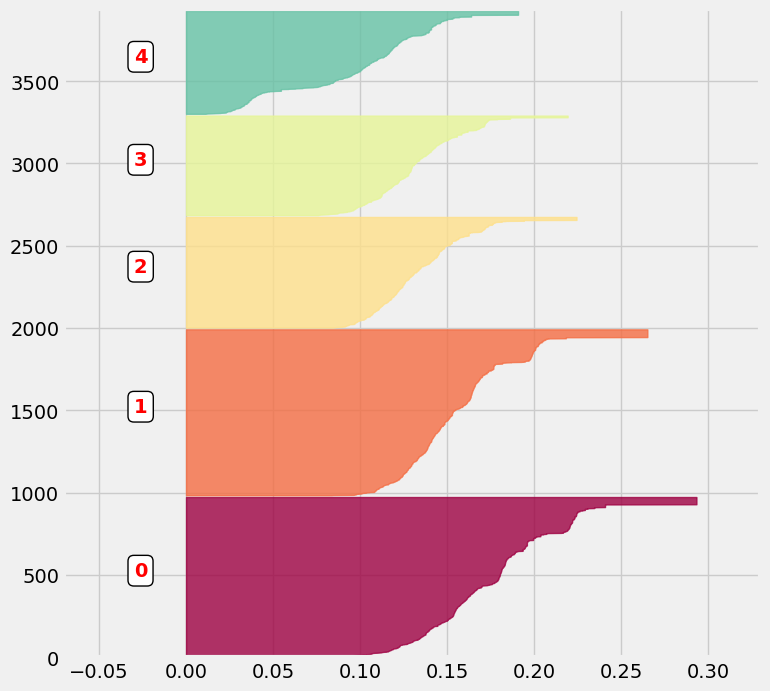

In [46]:
# define individual silouette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
# graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)
plt.show()

Word Cloud

In [47]:
# 각 클러스터링 번호별 단어 빈도 계산
liste = pd.DataFrame(liste_produnits) # 클러스터링 번호를 이용하여 데이터 프레임
liste_words = [word for (word, occurence) in list_products] # 불용어 제외한 단어

occurence = [dict() for _ in range(n_clusters)] # 클러스터별 단어 발생 빈도를 딕셔너리로 기록

for i in range(n_clusters):
  liste_cluster = liste.loc[clusters == i]
  for word in liste_words:
    if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
    # 데이터프레임의 첫 번째 열 해당 단어가 대문자로 포함된 텍스트가 몇 개인지를 계산하여 단어의 발생 빈도 구함
    occurence[i][word] =sum(liste_cluster.loc[:,0].str.contains(word.upper()))

In [48]:
# Word Cloud에서 단어의 색상을 랜덤하게 생성하기 위한 함수
def random_color_func(word = None, font_size = None, position =None,
                      orientation =None, font_path = None, random_state=None): # position 단어 위치, orientation 단어 방향,
  h = int(360.0 * tone/255.0) # 단어의 색조(Hue) 값을 계산
  s = int(100.0 * 255.0/255.0) # 단어의 채도(Saturation) 값을 100으로 설정
  l = int(100.0*float(random_state.randint(70,120))/255.0) # 단어의 명도(Lightness) 값을 랜덤하게 설정
  return 'hsl({}, {}%, {}%)'.format(h,s,l)

# Word Cloud를 생성하는 함수
def make_wordcloud(liste, increment):
  ax1 = fig.add_subplot(4,2,increment) # increment: Word Cloud를 그릴 때 subplot의 순서를 나타내는 값
  words =dict() # 단어를 담을 딕셔너리 생성
  trunc_occurences = liste[0:150] # 상위 150개
  for s in trunc_occurences:
    words[s[0]] = s[1]

  wordcloud = WordCloud(width =1000, height =400, background_color ='lightgray', max_words=1628, # 최대 단어 수
                        relative_scaling=1, # 단어 크기의 상대적 스케일링
                        color_func =random_color_func, normalize_plurals = False # 복수형 단어 정규화 여부
                        )
  wordcloud.generate_from_frequencies(words) # Word Cloud 생성
  ax1.imshow(wordcloud, interpolation ='bilinear')
  ax1.axis('off')
  plt.title('cluster n {}'.format(increment -1))

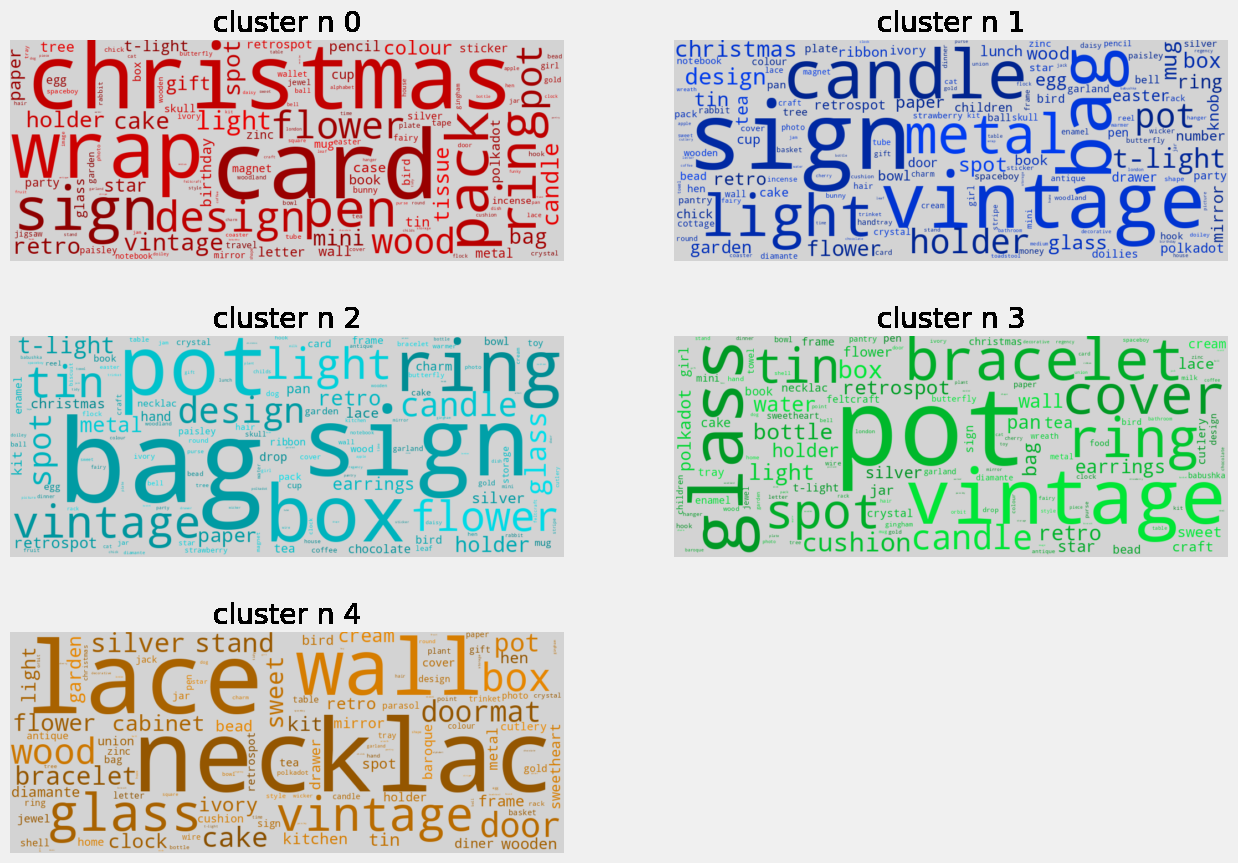

In [49]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
  list_cluster_occurences = occurence[i]
  tone =color[i]
  liste = []
  for key, value in list_cluster_occurences.items():
    liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

Principal Component Analysis (주성분 분석 PCA)



In [50]:
pca = PCA()
pca.fit(matrix)
pca_samples =pca.transform(matrix)

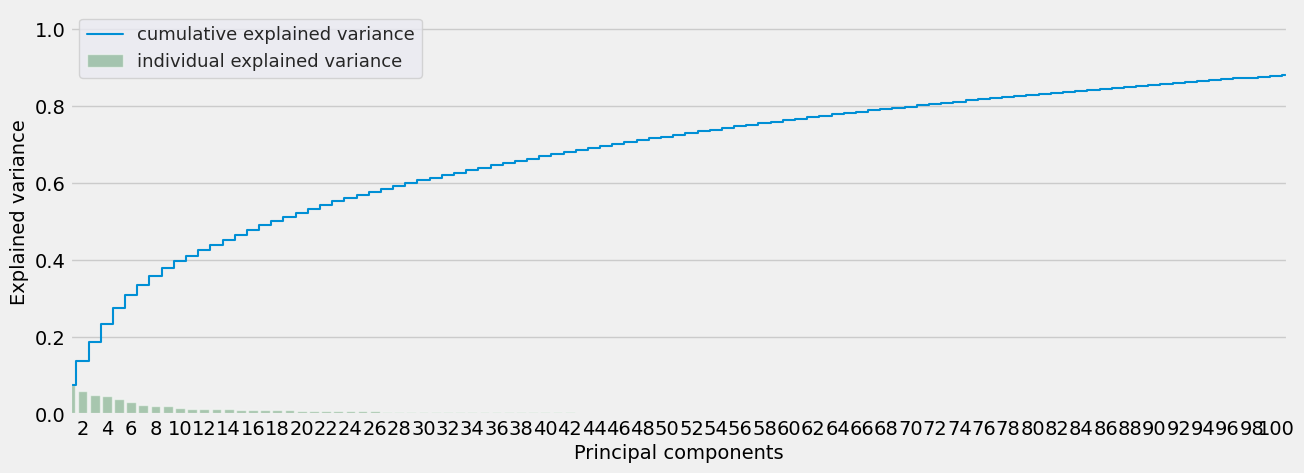

In [51]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
# 주성분 분석 결과의 누적 설명된 분산을 계단 형태의 그래프로 표시
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
# 주성분들의 개별적인 설명된 분산을 막대 그래프로 표시
sns.barplot(x=np.arange(1, matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color='g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [52]:
pca = PCA(n_components=50) # 주성분 개수
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [53]:
mat.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
0,0.040415,0.497232,0.088612,1.585316,-0.341044,-0.165394,0.682032,1.027609,0.750734,0.222193,...,0.001793,-0.019004,-0.011941,-0.158465,0.003254,-0.030247,-0.018540,-0.057115,0.029667,2
1,-0.018280,0.422522,0.560009,-0.433863,-0.344761,-0.180220,-0.252119,-0.004542,0.149700,-0.088563,...,-0.021076,-0.012373,0.023202,-0.013208,-0.002980,0.010033,0.059450,-0.013496,-0.059227,3
2,0.015640,0.315744,1.247443,0.749125,-0.505797,-0.011895,-0.163455,-0.125405,-0.027267,-0.015411,...,-0.161510,-0.013688,-0.006973,-0.433630,-0.112527,-0.094312,-0.135260,0.031542,-0.095357,3
3,-0.035558,0.467759,0.633832,-0.475288,-0.348020,-0.157527,-0.188365,0.065969,-0.049894,-0.041463,...,-0.194406,-0.330063,0.058081,0.139407,0.894755,0.512105,-0.233667,-0.432983,0.355353,3
4,0.008751,0.319166,1.232738,0.739152,-0.492982,-0.010323,-0.144201,-0.115430,-0.008459,0.004106,...,-0.046252,-0.068996,0.007817,-0.051628,0.025463,-0.083304,0.000970,0.007161,-0.073261,3


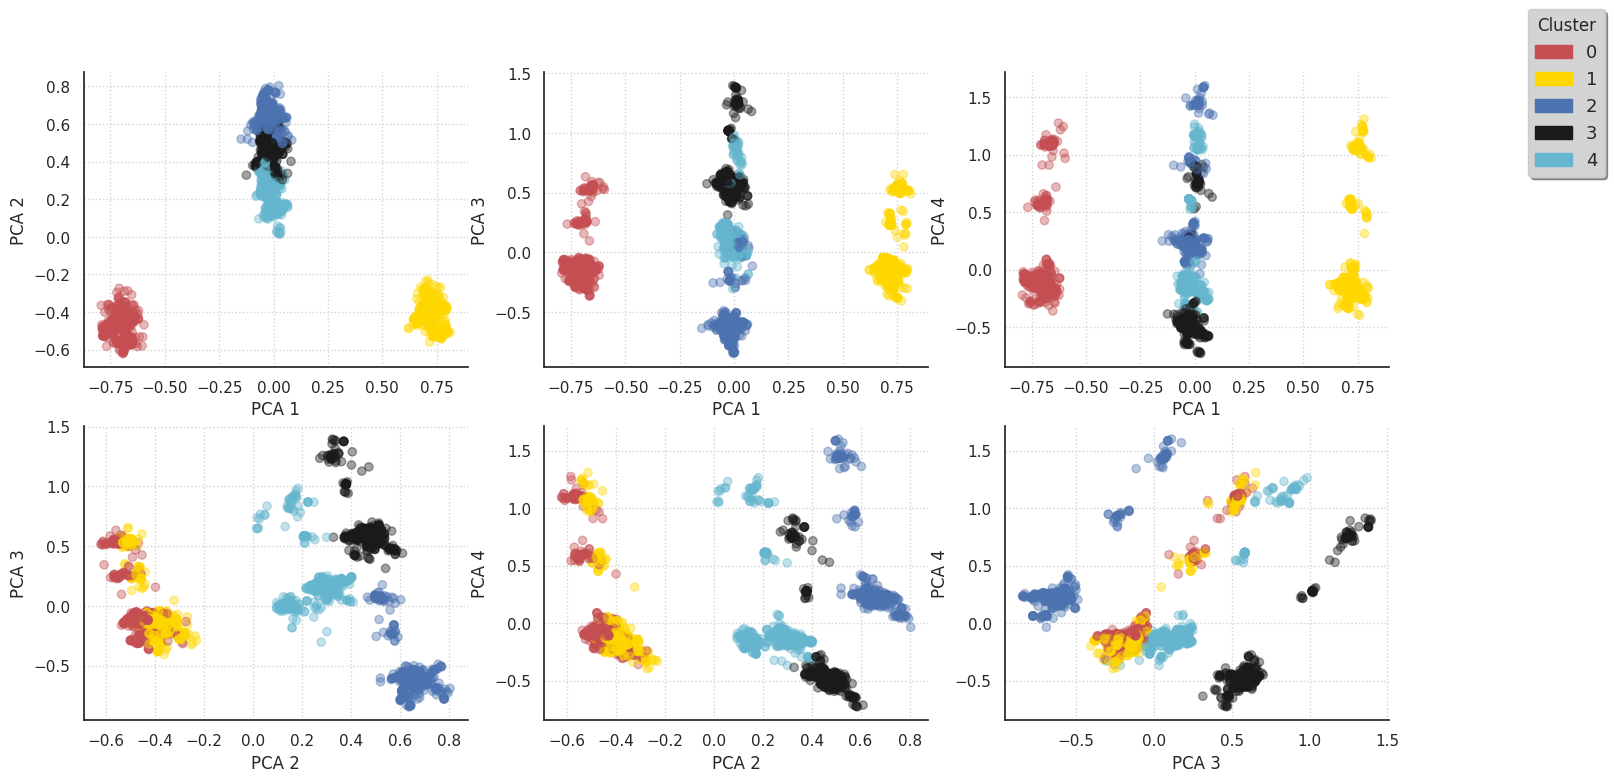

In [54]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9: break
    if increment == 9: break

#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

Customer categories

Formatting data

In [55]:
corresp = dict()

for key, val in zip (liste_produnits, clusters):
  corresp[key] = val

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

Grouping products

In [56]:
for i in range(5):
  col = 'categ_{}'.format(i)
